In [1221]:
import os
import json
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import matplotlib.patches as mpatches


In [1222]:
hospital_file = '..//YAIB-cohorts/data/mortality24/eicu/above2000.txt'
df = pd.read_csv(hospital_file, header=None)

In [1223]:
n = 12
hospital_ids = df[0].values[:n]
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i

## Section 1: Data Addition for 1 Hospital: 

In [1224]:
sem_ratio = np.sqrt(5)
hos=443
# hospital
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i
    
hos_ind = hospital_dict[hos]
model = "LogisticRegression"
n_avg = np.load(f"results/sequential-n/{hos}/{hos}-{model}-avg.npz", allow_pickle=True)
n_std = np.load(f"results/sequential-n/{hos}/{hos}-{model}-std.npz", allow_pickle=True)
dist_shift_avg = np.load(f"results/dist_shift/{model}-n1500-avg.npz")
dist_shift_std = np.load(f"results/dist_shift/{model}-n1500-std.npz")
data_addition_avg = np.load(f"results/add_data/{model}-avg.npz")
data_addition_std = np.load(f"results/add_data/{model}-std.npz")

# data_addition_std = np.load(f"results/add_data/{model}-n1500-std.npz")

with open('./results/add_data/num_addition.pk', 'rb') as handle:
    addition_dict = pickle.load(handle)

In [1225]:
plot_df = pd.DataFrame.from_dict(n_avg['AUC'].item(), orient='index', columns=['AUC'])
std_df = pd.DataFrame.from_dict(n_std['AUC'].item(), orient='index', columns=['std'])
plot_df = pd.concat([plot_df, std_df], axis=1)
new_df = plot_df.reset_index(names='n')
new_df['train_hospital'] = hos

In [1226]:
for i in range(len(hospital_ids)): 
    if hospital_ids[i] != hos: 
        new_hospital = {
            'n': addition_dict[hospital_ids[i]] + 2000, 
            'AUC': data_addition_avg['AUC'][:, hos_ind][i], 
            'std': data_addition_std['AUC'][:, hos_ind][i],
            'train_hospital': hospital_ids[i]
            }
        
        new_df.loc[len(new_df)] = new_hospital
        prev_result = new_df.loc[5].to_dict()
        prev_result['train_hospital'] = hospital_ids[i] 
        prev_result['std'] = 0
        new_df.loc[len(new_df)] = prev_result

new_df['sem'] = new_df['std']/sem_ratio

In [1227]:
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = 'lightgrey'


In [1228]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.coolwarm(np.linspace(0,1,11)))

In [1229]:
sort_idx = np.argsort(new_df.groupby('train_hospital').max()['AUC'].values)
sorted_hospital_ids = np.sort(hospital_ids)

In [1230]:
new_df.groupby('train_hospital').max()['AUC']

train_hospital
73     0.737726
167    0.737726
188    0.737726
199    0.747941
243    0.744908
252    0.737781
264    0.750611
300    0.754077
338    0.743204
420    0.753751
443    0.737726
458    0.754951
Name: AUC, dtype: float64

In [1231]:
plt.rcParams['axes.labelsize'] = 20


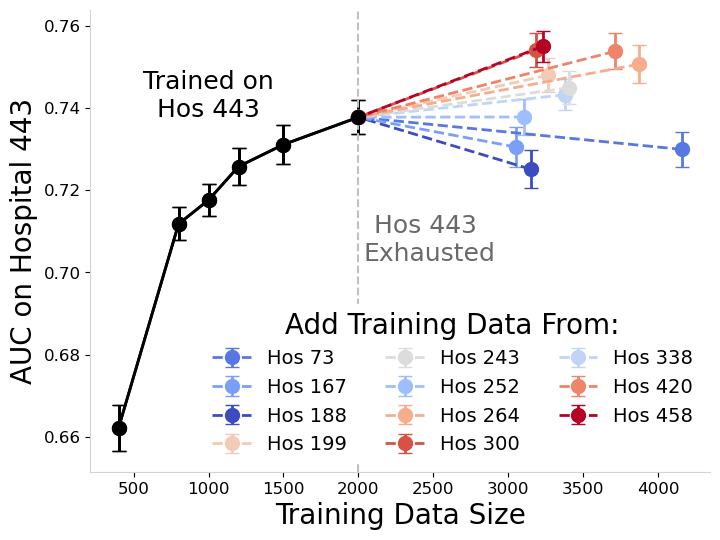

In [1232]:
fig, ax = plt.subplots(figsize=(8, 6))
markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', 'P', '*', 'X', 'D']

sort_idx = np.argsort(new_df[new_df['n'] != 2000].groupby('train_hospital').max()['AUC'].values)
sorted_hospital_ids = np.sort(hospital_ids)

# move black plot to end
sort_idx = np.concatenate([sort_idx[:hos_idx],sort_idx[hos_idx:],[hos_idx]])
# sorted_hospital_ids = 
# Plot the mean AUC with confidence intervals as vertical bars
# for i in range(len(hospital_ids)): 
for i in sort_idx:
    hos_df = new_df[new_df['train_hospital'] == sorted_hospital_ids[i]]
    if sorted_hospital_ids[i] == hos:
        ax.errorbar(x=hos_df['n'],
                y=hos_df['AUC'],
                yerr=[hos_df['sem'] ,hos_df['sem']],
                fmt='o-',
                capsize=5,
                lw=2,
                ms=10,
                color='k'
               )
    else:
        label = f'Hos {sorted_hospital_ids[i]}'
        ax.errorbar(x=hos_df['n'],
                y=hos_df['AUC'],
                yerr=[hos_df['sem'] ,hos_df['sem']],
                fmt='o',
                ls='--',
                capsize=5,
                label=label,
                lw=2,
                ms=10,
               )
#         ax.plot([hos_df['n'].values[-1]], [hos_df['AUC'].values[-1]],marker='o',label='hi'
#                 ms=10, marker='o',color='k'
#                )
    

# Set labels and title
ax.set_xlabel('Training Data Size')
ax.set_ylabel(f'AUC on Hospital {hos}')
ax.axvline(2000,color='silver', ls='--')

ax.annotate(f'Hos {hos} \nExhausted',
            color='dimgray',
            xy=(2475, 0.70),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center', va=va, fontsize=18)

ax.annotate(f'Trained on\nHos {hos}',
            color='k',
            xy=(1000, 0.735),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center', va=va, fontsize=18)

    

# Show the legend
handles,labels = ax.get_legend_handles_labels()
zip_hand_lab = zip(handles, labels)
test = sorted(zip_hand_lab, key=lambda x: int(x[1].split(' ')[1]))
handles2, labels2 = zip(*test)

leg = ax.legend(handles2, labels2, frameon=True,ncols=3, fontsize=14,
                loc=4,framealpha=1., facecolor='white', edgecolor='white')
leg.set_title('Add Training Data From:',prop={'size':20})

# Display the plot
plt.savefig('figures/hosp443lr_adddata.pdf',bbox_inches='tight')

## Section 2: Distribution Shift Across All Hospitals

In [1233]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)


In [1234]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = 'lightgrey'


LogisticRegression Train-Test AUC drop across hospitals


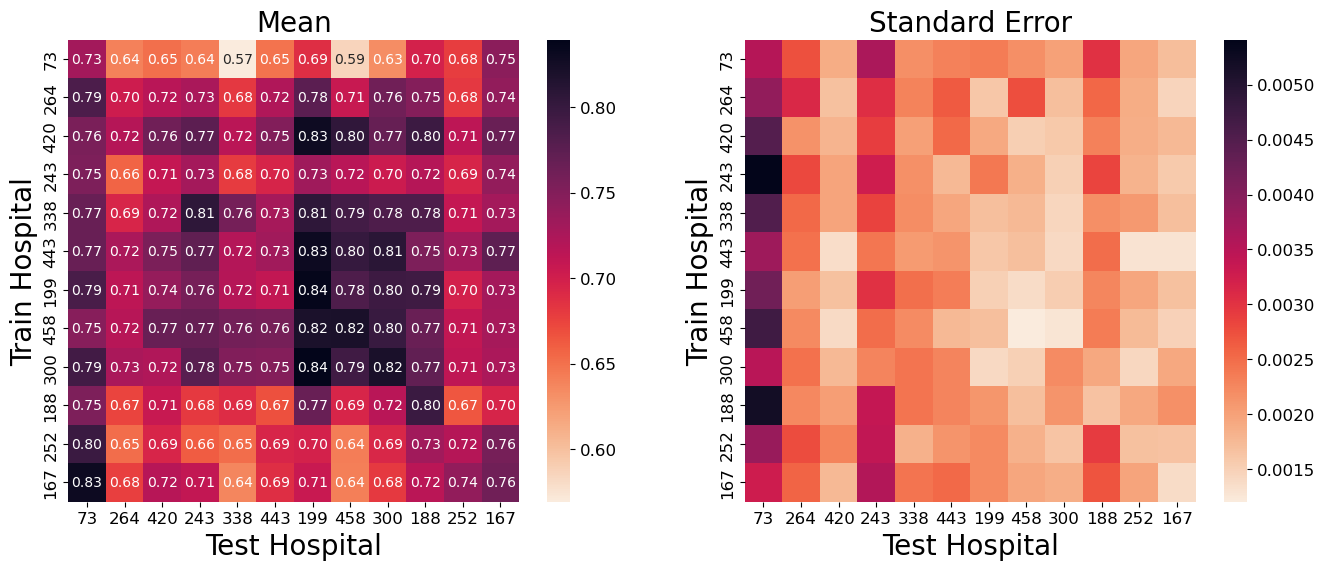

In [1235]:
metric = 'AUC'
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)

sns.heatmap(dist_shift_avg[metric], annot=True, cmap="rocket_r", ax=axes[0], 
                      xticklabels=hospital_ids, 
                                   fmt=".2f",
#                 cbar_kws={'label': 'Mean'},
           yticklabels=hospital_ids,)
axes[0].set_xlabel("Test Hospital")
axes[0].set_ylabel("Train Hospital")
axes[0].set_title("Mean",fontsize=20)

sns.heatmap(dist_shift_std[metric]/np.sqrt(25), fmt=".2e", annot=False, annot_kws={'fontsize':7}, cmap="rocket_r", 
                      xticklabels=hospital_ids, 
           yticklabels=hospital_ids,
#                        fmt=".2f",
#            cbar_kws={'label': f'{model} {metric} Change'})
#             cbar_kws={'label': f'{metric} Change'})
)
axes[1].set_xlabel("Test Hospital")
axes[1].set_ylabel("Train Hospital")
axes[1].set_title("Standard Error",fontsize=20)

# plt.suptitle(f"{model} Train-Test {metric} drop across hospitals")
print(f"{model} Train-Test {metric} drop across hospitals")
plt.savefig('figures/train_test_heatmap.pdf', bbox_inches='tight')

In [1236]:
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

LogisticRegression AUC Change Between Train and Test Hospitals


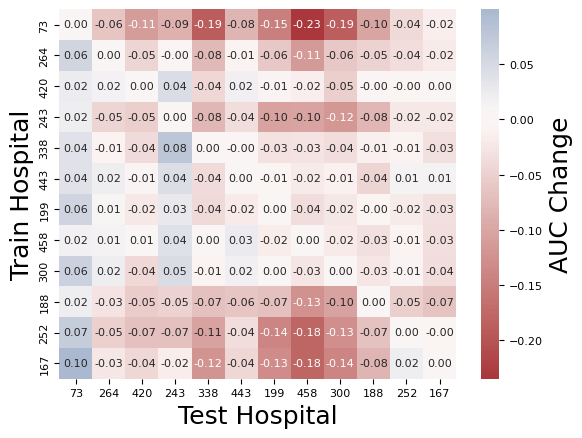

In [1237]:
# Differences
diff = dist_shift_avg[metric] - np.repeat(np.diagonal(dist_shift_avg[metric]).reshape(-1, 1), len(hospital_ids), axis=1).T
sns.heatmap(diff, annot=True, 
            annot_kws={'fontsize':8}, cmap="vlag_r", 
           xticklabels=hospital_ids, 
           yticklabels=hospital_ids,
           center=0,
            fmt=".2f",
#            cbar_kws={'label': f'{model} {metric} Change'})
            cbar_kws={'label': f'{metric} Change'})
plt.xlabel("Test Hospital")
plt.ylabel("Train Hospital")
print(f"{model} {metric} Change Between Train and Test Hospitals")
plt.savefig('figures/train_test_aucchange.pdf',bbox_inches='tight')
# plt.title(f"{model} {metric} Change Between Train and Test Hospitals")

In [1238]:
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = 'lightgrey'


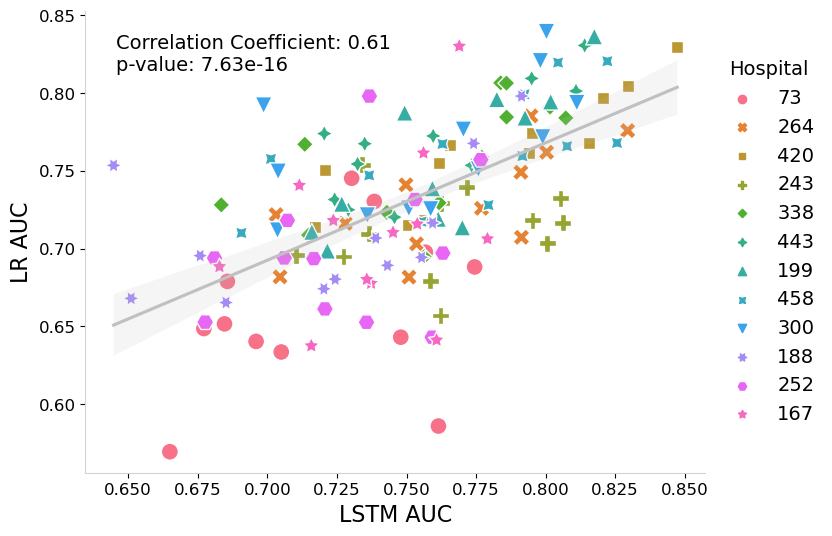

In [1239]:
LR = np.load('results/dist_shift/LogisticRegression-n1500-avg.npz')
LGBM = np.load('results/dist_shift/LGBMClassifier-n1500-avg.npz')
# TODO: change to n1500
LSTM = np.load('results/dist_shift/LSTM-avg.npz')

metric = 'AUC'
plot_df = pd.DataFrame()
plot_df['LR'] = LR[metric].flatten()
plot_df['LGBM'] = LGBM[metric].flatten()
plot_df['LSTM'] = LSTM[metric].flatten()
plot_df['train_hospital'] = np.repeat(hospital_ids, repeats=len(hospital_ids))
plot_df['train_hospital'] = plot_df['train_hospital'].astype(str)
plot_df['test_hospital'] = np.repeat(hospital_ids.reshape(-1, 1), repeats=len(hospital_ids), axis=1).T.flatten()

clf1 = 'LSTM'
clf2 = 'LR'
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=plot_df, x=clf1, y=clf2, hue='train_hospital', s=150, style='train_hospital')
sns.regplot(x=clf1, y=clf2, data=plot_df,scatter=False,color='silver')


# leg = ax.legend(frameon=False,ncols=3)
# leg.set_title('Add Data from:',prop={'size':14})


corr_coef, p_value = pearsonr(plot_df[clf1], plot_df[clf2])

# Add correlation coefficient and p-value to the plot
text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2e}'
ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
        fontsize=14, verticalalignment='top')
leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=14)
leg.set_title('Hospital',prop={'size':14})

ax.set_xlabel(f'{clf1} {metric}')
ax.set_ylabel(f'{clf2} {metric}')
plt.savefig('figures/lr_lstm_scatter.pdf', bbox_inches='tight')
# ax.set_title(f'{clf1} vs. {clf2}  Correlation')

In [1240]:
metric = 'AUC'
keys_gender = [(f'{metric}', 'All'), 
               (f'gender0_{metric}_TEST', 'Female'),  
                (f'gender1_{metric}_TEST', 'Male')]
keys_race = [(f'{metric}', 'All'),
        (f'race0_{metric}_TEST', 'Asian'), 
        (f'race1_{metric}_TEST', 'Black'), 
        (f'race2_{metric}_TEST', 'Other'),
        (f'race3_{metric}_TEST', 'White')]

In [1241]:
plt.rcParams['axes.labelsize'] = 20

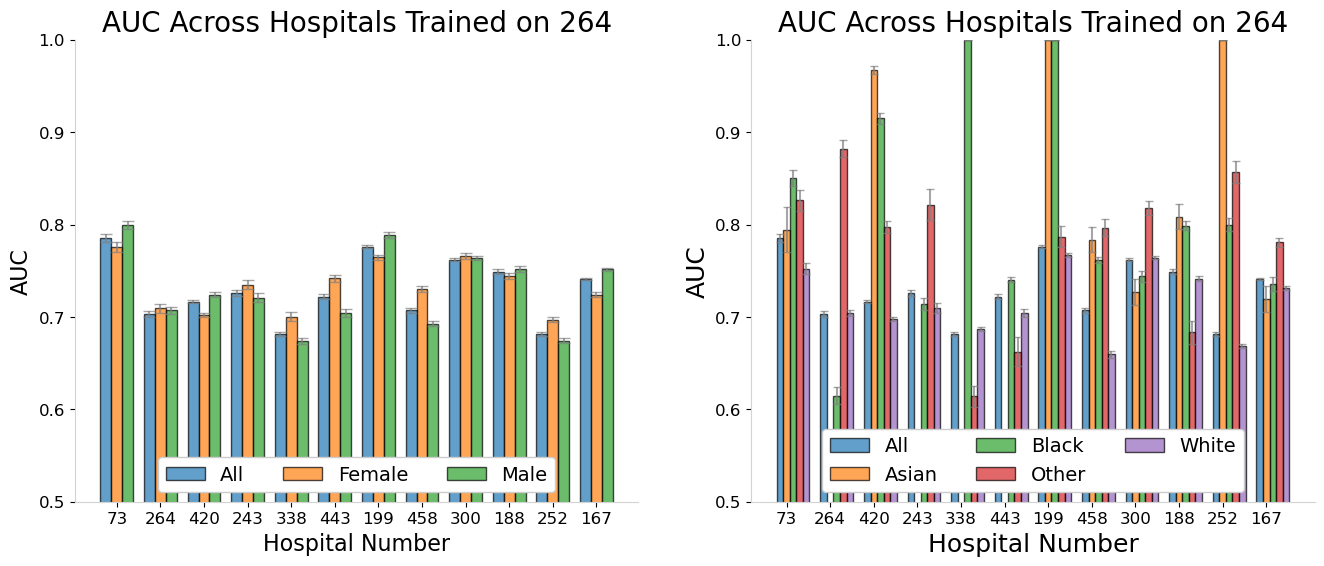

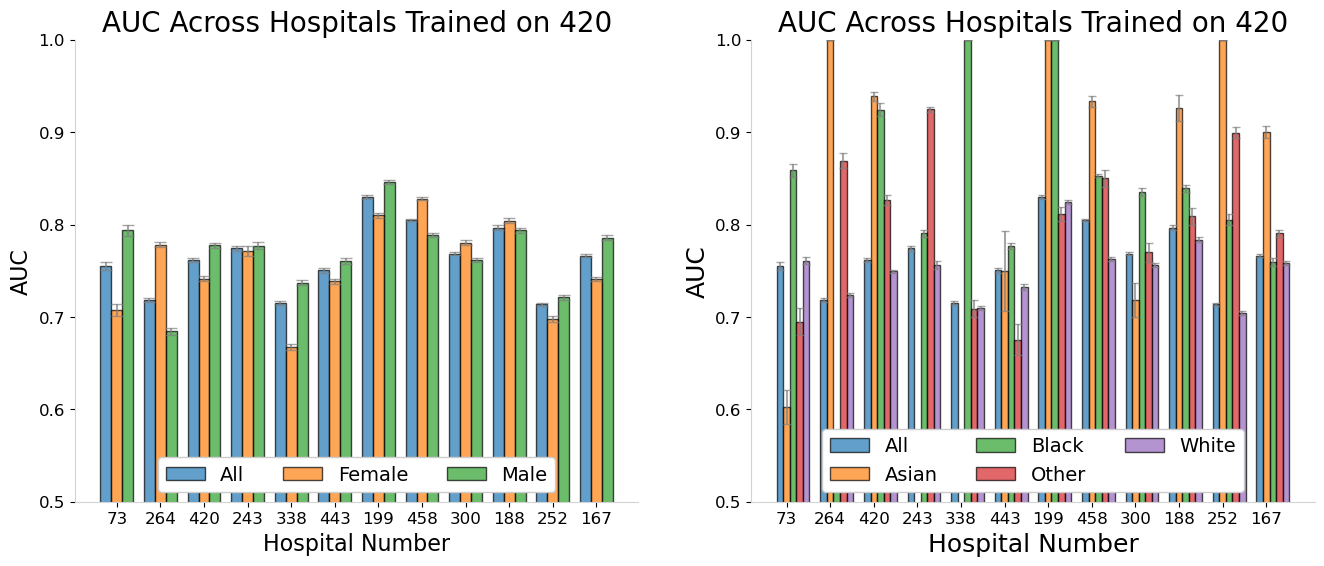

In [1242]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

# gender_colors = ['#5c5c5c', '#8a2df6', 'forestgreen']
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
# for train hospital 73
for train_hid in [1, 2]:  
    
    # Plot the bars
#     plt.rcParams['axes.prop_cycle'] = plt.cycler(color=gender_colors)
    fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
    # Set the bar positions and width
    bar_positions = np.arange(len(hospital_ids))
    bar_width = 0.25
    
    ax = axes[0]
    for i, (key, label) in enumerate(keys_gender): 
        
        auc_values = dist_shift_avg[key][train_hid]
        std = dist_shift_std[key][train_hid]
        sem = std/np.sqrt(25)
        
        
        bars = ax.bar(bar_positions+i*bar_width, 
                      auc_values, bar_width, alpha=0.7, 
                      edgecolor='black', label=label)
        
        # Plot the error bars
        error_bars = ax.errorbar(bar_positions+i*bar_width,
                                 auc_values, 
                                 yerr=[sem, sem], 
                                 capsize=4, fmt='none', ecolor='gray', alpha=0.7)
        
        # Add labels and titles
        ax.set_xticks(bar_positions+bar_width)
        ax.set_ylim(0.5,1)
        ax.set_xticklabels(hospital_ids)
        ax.set_ylabel(f'{metric}', fontsize=16)
        ax.set_xlabel('Hospital Number', fontsize=16)
        ax.set_title(f'{metric} Across Hospitals Trained on {hospital_ids[train_hid]}', fontsize=20)
        ax.legend(ncols=5,loc=8,fontsize=14,framealpha=1)
    
    bar_width = 0.15
    plt.savefig(f'figures/hos{hospital_ids[train_hid]}_auc_subgroups.pdf', bbox_inches='tight')

    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
    
    ax = axes[1]
    for i, (key, label) in enumerate(keys_race): 
        auc_values = dist_shift_avg[key][train_hid]
        std = dist_shift_std[key][train_hid]
        sem = std/np.sqrt(25)
        
        
        bars = ax.bar(bar_positions+i*bar_width, 
                      auc_values, bar_width, alpha=0.7, 
                      edgecolor='black', label=label,
#                      color=plt.cm.tab10.colors
                     )
        
        # Plot the error bars
        error_bars = ax.errorbar(bar_positions+i*bar_width,
                                 auc_values, 
                                 yerr=[sem, sem], 
                                 capsize=3, fmt='none', ecolor='gray', alpha=0.7)
        
        # Add labels and titles
        ax.set_xticks(bar_positions+bar_width)
        ax.set_ylim(0.5,1)
        ax.set_xticklabels(hospital_ids)
        ax.set_ylabel(f'{metric}', fontsize=18)
        ax.set_xlabel('Hospital Number', fontsize=18)
        ax.set_title(f'{metric} Across Hospitals Trained on {hospital_ids[train_hid]}', fontsize=20)
        ax.legend(ncols=3,loc=8,fontsize=14,framealpha=1)
        
        # # Adjust the y-axis limits
        
        # # Add value labels on top of the bars
        # for bar, auc in zip(bars, auc_values):
        #     height = bar.get_height() +0.04
        #     print(height)
        #     ax.annotate(f'{auc:.2f}',
        #                 xy=(bar.get_x() + bar.get_width() / 2, height),
        #                 xytext=(0, 3),
        #                 textcoords="offset points",
        #                 ha='center', va='bottom', fontsize=10)
        
    plt.savefig(f'figures/hos{hospital_ids[train_hid]}_auc_subgroups.pdf', bbox_inches='tight')

## Section 3: Data Addition

In [1243]:
# load required data 
# TODO: Change to n1500
model = 'LogisticRegression'
data_addition_avg = np.load(f"results/add_data/{model}-n1500-avg.npz")
data_addition_std = np.load(f"results/add_data/{model}-n1500-std.npz")
dist_shift_avg = np.load(f"results/dist_shift/{model}-n1500-avg.npz")

In [1244]:
# for disparity, take max diff across four races; if 0 then no race in test set

In [1245]:
for k in data_addition_avg.files:
    print(k)


loss
AUC
PR
ACC_TEST
BACC_TEST
AUC_TEST
gender0_AUC_TEST
gender0_BACC_TEST
gender0_ACC_TEST
gender1_AUC_TEST
gender1_BACC_TEST
gender1_ACC_TEST
race2_AUC_TEST
race2_BACC_TEST
race2_ACC_TEST
race3_AUC_TEST
race3_BACC_TEST
race3_ACC_TEST
race1_AUC_TEST
race1_BACC_TEST
race1_ACC_TEST
race0_AUC_TEST
race0_BACC_TEST
race0_ACC_TEST


In [1246]:
data_addition_avg.keys()

KeysView(<numpy.lib.npyio.NpzFile object at 0x7fb036551be0>)

LogisticRegression Train-Test AUC drop across hospitals


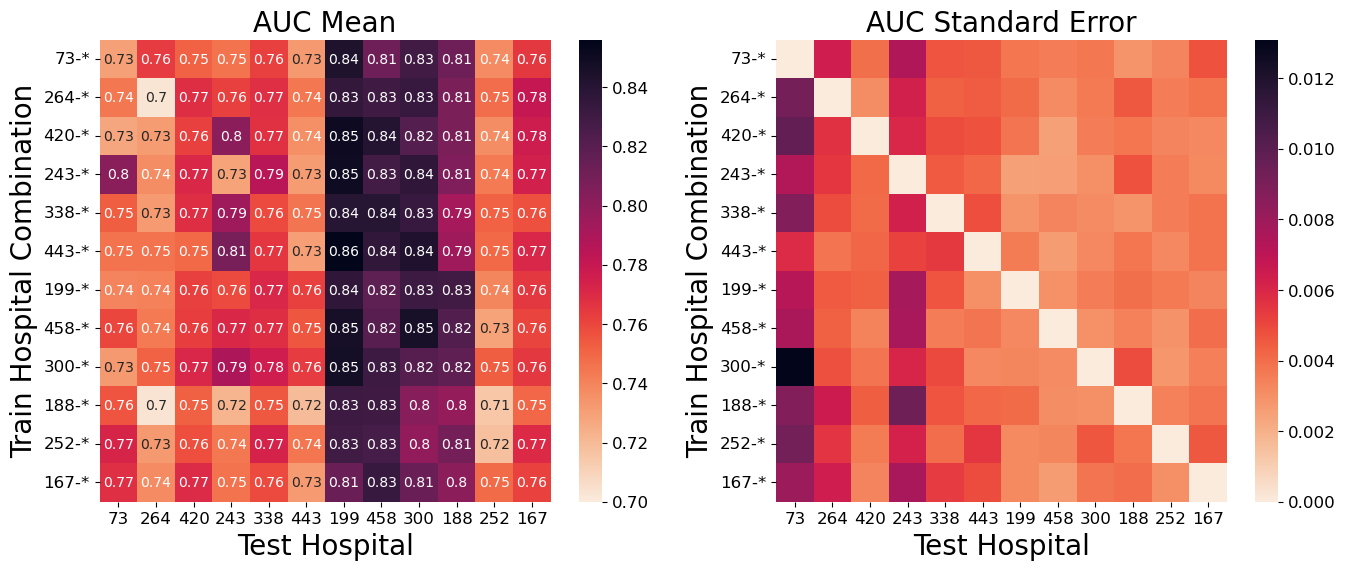

In [1247]:
metric = 'AUC'
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
train_test_ids = [f"{h}-*" for h in hospital_ids]
plot_mat = data_addition_avg[metric] + np.diagonal(dist_shift_avg[metric])*np.eye(len(hospital_ids)) 
           
sns.heatmap(plot_mat, annot=True, cmap="rocket_r", ax=axes[0], 
            xticklabels=hospital_ids, 
           yticklabels=train_test_ids, 
           vmin=0.7)
axes[0].set_xlabel("Test Hospital")
axes[0].set_ylabel("Train Hospital Combination")
axes[0].set_title(f"{metric} Mean",fontsize=20)

sns.heatmap(data_addition_std[metric]/sem_ratio, fmt=".2e", annot_kws={'fontsize':7}, cmap="rocket_r", 
                      xticklabels=hospital_ids, 
           yticklabels=train_test_ids,)
axes[1].set_xlabel("Test Hospital")
axes[1].set_ylabel("Train Hospital Combination")
axes[1].set_title(f"{metric} Standard Error",fontsize=20)

# plt.suptitle(f"{model} Train-Test {metric} drop across hospitals")
print(f"{model} Train-Test {metric} drop across hospitals")
plt.savefig('figures/hosp_addition_AUC_lr.pdf', bbox_inches='tight')

In [1248]:
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

LogisticRegression AUC Change Between Train and Test Hospitals


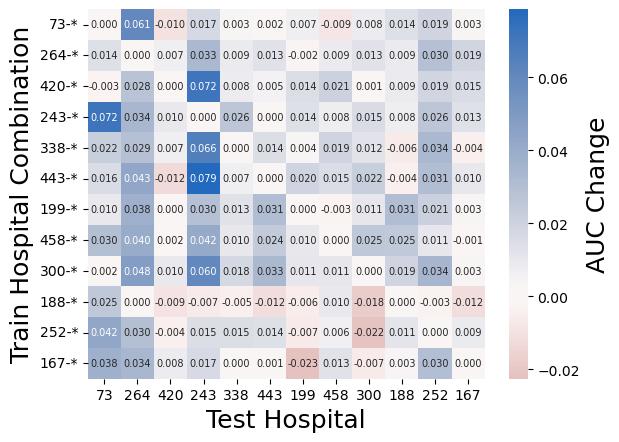

In [1249]:
addition_diff = plot_mat - np.repeat(np.diagonal(dist_shift_avg[metric]).reshape(-1, 1), len(hospital_ids), axis=1).T
sns.heatmap(addition_diff, annot=True, 
            annot_kws={'fontsize':7}, cmap="vlag_r", 
           xticklabels=hospital_ids, 
           yticklabels=train_test_ids,
           center=0,
            fmt=".3f",
           cbar_kws={'label': f'{metric} Change'})
plt.xlabel("Test Hospital")
plt.ylabel("Train Hospital Combination")
# plt.title(f"{model} {metric} Change Between Train and Test Hospitals")
print(f"{model} {metric} Change Between Train and Test Hospitals")
plt.savefig('figures/hosp_addition_AUCchange_lr.pdf',bbox_inches='tight')

LogisticRegression Train-Test race0_ACC_TEST drop across hospitals
LogisticRegression race0_ACC_TEST Change Between Train and Test Hospitals


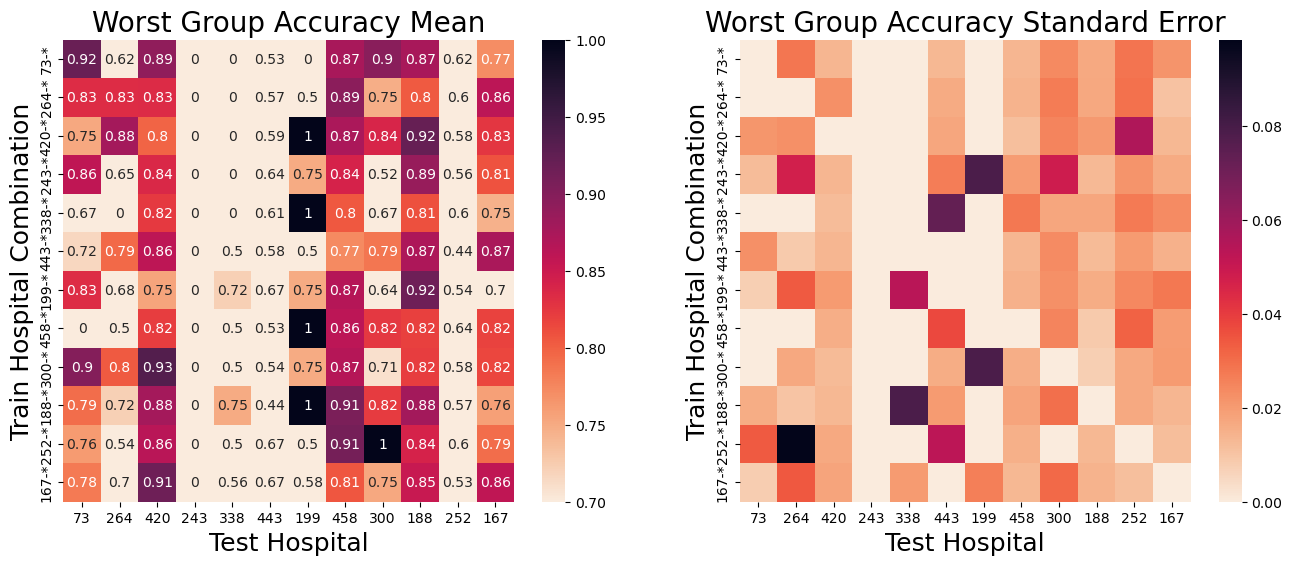

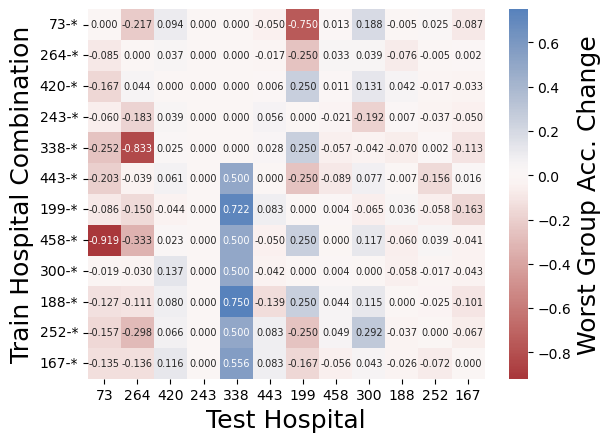

In [1250]:
metric = 'race0_ACC_TEST'
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
train_test_ids = [f"{h}-*" for h in hospital_ids]
plot_mat = data_addition_avg[metric] + np.diagonal(dist_shift_avg[metric])*np.eye(len(hospital_ids)) 
           
sns.heatmap(plot_mat, annot=True, cmap="rocket_r", ax=axes[0], 
            xticklabels=hospital_ids, 
           yticklabels=train_test_ids, 
           vmin=0.7)
axes[0].set_xlabel("Test Hospital")
axes[0].set_ylabel("Train Hospital Combination")
axes[0].set_title("Worst Group Accuracy Mean",fontsize=20)

sns.heatmap(data_addition_std[metric]/sem_ratio, fmt=".2e", annot_kws={'fontsize':7}, cmap="rocket_r", 
                      xticklabels=hospital_ids, 
           yticklabels=train_test_ids,)
axes[1].set_xlabel("Test Hospital")
axes[1].set_ylabel("Train Hospital Combination")
axes[1].set_title("Worst Group Accuracy Standard Error",fontsize=20)

# plt.suptitle(f"{model} Train-Test {metric} drop across hospitals")
print(f"{model} Train-Test {metric} drop across hospitals")
plt.savefig('figures/hosp_addition_AUC_race0_lr.pdf', bbox_inches='tight')

plt.figure()

######################
addition_diff = plot_mat - np.repeat(np.diagonal(dist_shift_avg[metric]).reshape(-1, 1), len(hospital_ids), axis=1).T
sns.heatmap(addition_diff, annot=True, 
            annot_kws={'fontsize':7}, cmap="vlag_r", 
           xticklabels=hospital_ids, 
           yticklabels=train_test_ids,
           center=0,
            fmt=".3f",
           cbar_kws={'label': f'Worst Group Acc. Change'})
plt.xlabel("Test Hospital")
plt.ylabel("Train Hospital Combination")
# plt.title(f"{model} {metric} Change Between Train and Test Hospitals")
print(f"{model} {metric} Change Between Train and Test Hospitals")
plt.savefig('figures/hosp_addition_AUCchange_race0_lr.pdf',bbox_inches='tight')

In [1251]:
plot_df['OOD'] = diff.flatten()
plot_df['Data-Addition'] = addition_diff.flatten()

LogisticRegression Out of Data vs. Data-Addition Correlation


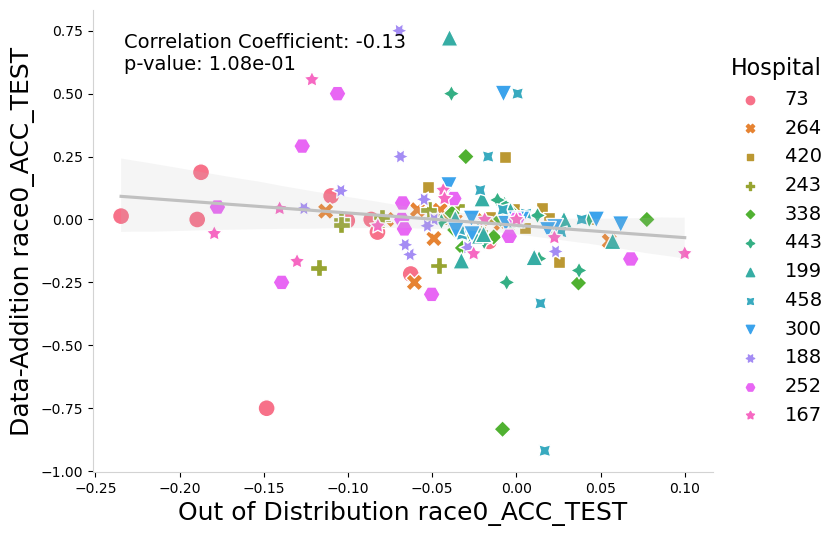

In [1252]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=plot_df, x='OOD', y='Data-Addition', hue='train_hospital', style='train_hospital', s=150)
sns.regplot(x='OOD', y='Data-Addition', data=plot_df,scatter=False,color='silver')

corr_coef, p_value = pearsonr(plot_df['OOD'], plot_df['Data-Addition'])

# Add correlation coefficient and p-value to the plot
text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2e}'
ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
        fontsize=14, verticalalignment='top')
leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=14)
leg.set_title('Hospital',prop={'size':16})


ax.set_xlabel(f'Out of Distribution {metric}')
ax.set_ylabel(f'Data-Addition {metric}')
# ax.set_title(f'{model} Out of Data vs. Data-Addition Correlation')
print(f'{model} Out of Data vs. Data-Addition Correlation')
plt.savefig('figures/dataadd_ood_auc_lr.pdf', bbox_inches='tight')

### Section 2B/3B: Correlation

In [1253]:
# load data
metric = 'AUC'
LR_AUC = np.load('results/dist_shift/LogisticRegression-AUC-n1500-diff-avg.npz')[metric]
LGBM_AUC = np.load('results/dist_shift/LGBMClassifier-AUC-n1500-diff-avg.npz')[metric]
LSTM_AUC = np.load('results/dist_shift/LSTM-AUC-n1500-diff-avg.npz')[metric]
# TODO: Add LGBM and LSTM for 1500 
with open('results/add_data/LogisticRegression-AUC-n1500-diff-avg.npy', 'rb') as f: 
    LR_ADD_AUC = np.load(f)
 
# KL load
with open('results/distances/KL-ratio-x-true.npy', 'rb') as f: 
    ratio_x = np.load(f)
with open('results/distances/KL-ratio-xy-true.npy', 'rb') as f: 
    ratio_xy = np.load(f)

# KL load
with open('results/distances/score-x.npy', 'rb') as f: 
    score_x = np.load(f)
with open('results/distances/score-xy.npy', 'rb') as f: 
    score_xy = np.load(f)
    
with open('results/distances/KL-ratio-addition-x.npy', 'rb') as f: 
    add_ratio_x = np.load(f)
with open('results/distances/KL-ratio-addition-xy.npy', 'rb') as f: 
    add_ratio_xy = np.load(f)

with open("results/distances/distance_metrics.pk", 'rb') as file:
    # Load the data from the pickle file
    data = pickle.load(file)



In [1254]:
plot_df = pd.DataFrame()
plot_df['LR'] = LR_AUC.flatten()
plot_df['LGBM'] = LGBM_AUC.flatten()
plot_df['LSTM'] = LSTM_AUC.flatten()

plot_df['LR-ADD'] = LR_ADD_AUC.flatten()
plot_df['train_hospital'] = np.repeat(hospital_ids[:n], repeats=n)
plot_df['train_hospital'] = plot_df['train_hospital'].astype(str)
plot_df['test_hospital'] = np.repeat(hospital_ids[:n].reshape(-1, 1), repeats=n, axis=1).T.flatten()
plot_df['test_hospital'] = plot_df['test_hospital'].astype(str)
plot_df['KL_ratio_x'] = ratio_x.flatten() 
plot_df['KL_ratio_xy'] = ratio_xy.flatten() 
plot_df['score_x'] = score_x.flatten() 
plot_df['score_xy'] = score_xy.flatten() 
plot_df['KL_add_ratio_x'] = add_ratio_x.flatten() 
plot_df['KL_add_ratio_xy'] = add_ratio_xy.flatten() 

for key in data.keys(): 
    dist = data[key]
    dist_pairwise = np.zeros((len(hospital_ids), len(hospital_ids)))
    for i, j in dist.keys(): 
        dist_pairwise[hospital_dict[i], hospital_dict[j]] = dist[(i, j)]
    plot_df[key] = dist_pairwise.flatten()

# remove zeros
plot_df = plot_df.drop(np.arange(0, n)*(n+1))

In [1255]:
plot_df[plot_df['test_hospital']=='199'].sort_values(by='score_xy')

,LR,LGBM,LSTM,LR-ADD,train_hospital,test_hospital,KL_ratio_x,KL_ratio_xy,score_x,score_xy,KL_add_ratio_x,KL_add_ratio_xy,mort_dist,racemort_dist,agemort_dist,sexmort_dist,ct_dist,age_dist,sex_dist,race_dist
102,0.003005,-0.033742,-0.043515,-0.001318,300,199,0.602932,0.602058,0.589448,0.589306,-0.325042,-0.313937,0.313175,0.233980,0.065290,0.013906,0.245077,0.053361,0.037518,0.154197
90,-0.016843,-0.025222,-0.060769,-0.002431,458,199,0.727539,0.725035,0.593103,0.592598,-0.326016,-0.323279,0.403688,0.256272,0.099972,0.047444,0.557108,0.067647,0.046288,0.443173
138,-0.130279,-0.107446,-0.053140,-0.034941,167,199,0.829207,0.830580,0.617385,0.617914,-0.296681,-0.306531,0.299306,0.212112,0.057231,0.029963,0.377056,0.060890,0.002364,0.313802
54,-0.030090,-0.080116,-0.090037,-0.008730,338,199,0.825320,0.825389,0.638503,0.638686,-0.321176,-0.322937,0.225232,0.149018,0.054960,0.021254,0.077893,0.024987,0.007166,0.045740
30,-0.006967,-0.026581,-0.026596,0.001868,420,199,0.973197,0.970331,0.653867,0.653525,-0.211741,-0.235360,0.353632,0.235837,0.080466,0.037329,0.194967,0.045553,0.023610,0.125804
42,-0.104062,-0.148617,-0.077899,0.001328,243,199,1.122970,1.129942,0.652415,0.653830,-0.303486,-0.317965,0.495629,0.353305,0.089822,0.052503,0.470136,0.031533,0.009879,0.428725
18,-0.060602,-0.089993,-0.045051,-0.014154,264,199,1.084251,1.079237,0.661419,0.660439,-0.247032,-0.187645,0.389096,0.313224,0.051112,0.024760,0.186480,0.042007,0.061738,0.082736
114,-0.068852,-0.040106,-0.052966,-0.018291,188,199,1.121623,1.119531,0.664831,0.664518,-0.182192,-0.288631,0.358163,0.277510,0.064689,0.015964,0.391173,0.041154,0.040492,0.309527
66,-0.005813,-0.040056,-0.046041,0.007174,443,199,1.789076,1.791594,0.687054,0.687204,-0.239701,-0.239617,0.339476,0.253972,0.069022,0.016482,0.927098,0.178319,0.015015,0.733765
126,-0.139444,-0.095806,-0.049779,-0.019148,252,199,1.678891,1.696442,0.725441,0.727499,-0.281980,-0.271665,0.204920,0.074993,0.088466,0.041460,0.130996,0.050313,0.002318,0.078366


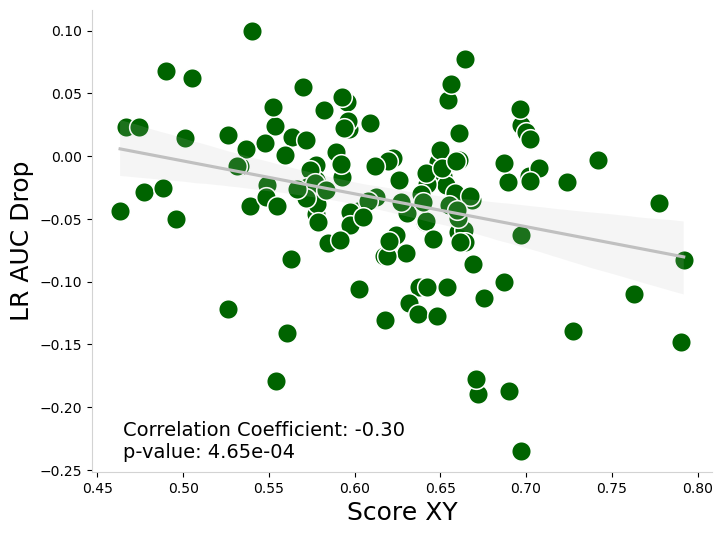

In [1256]:
clf = 'LR'
dist = 'score_xy'

selected_df = plot_df
# selected_df = plot_df[plot_df['test_hospital']=='443']
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=selected_df, y=clf, x=dist, c='darkgreen',s=200)
# sns.scatterplot(data=selected_df, y=clf, x=dist, style='train_hospital', hue='train_hospital',s=200)

sns.regplot(x=dist, y=clf, data=selected_df,scatter=False,color='silver')


corr_coef, p_value = pearsonr(selected_df[clf], selected_df[dist])

# Add correlation coefficient and p-value to the plot
text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2e}'
ax.text(0.05, 0.11, text_str, transform=ax.transAxes,
        fontsize=14, verticalalignment='top')
ax.set_xlabel('Score XY')
ax.set_ylabel('LR AUC Drop')
# leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=14)

# leg.set_title('Hospital',prop={'size':16})

plt.savefig('figures/lr_scorexy.pdf', bbox_inches='tight')
# plt.show()
# plt.close()

In [1257]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 24

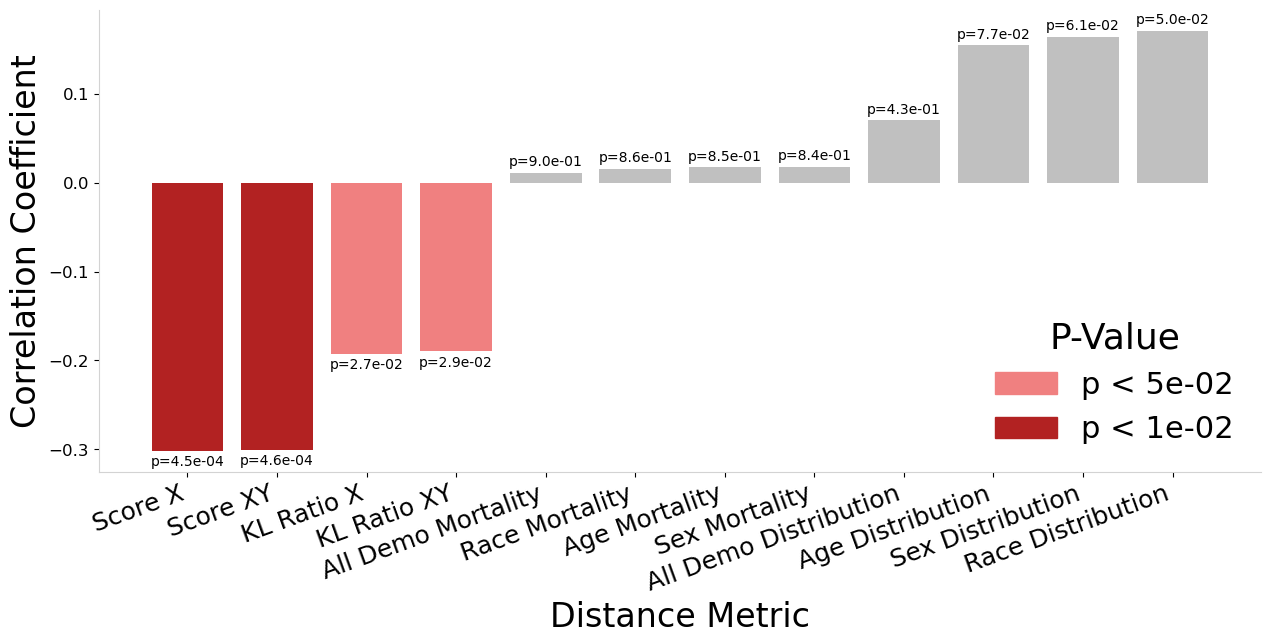

In [1258]:
# List of columns to compute correlation with 'LR'
cols = ['score_x', 'score_xy', 'KL_ratio_x', 'KL_ratio_xy', 'mort_dist', 
        'racemort_dist', 'agemort_dist', 'sexmort_dist', 'ct_dist', 
        'age_dist', 'sex_dist', 'race_dist']

# Compute correlation coefficients and p-values
corr_coefs = []
p_values = []
for col in cols:
    corr_coef, p_val = pearsonr(plot_df['LR'], plot_df[col])
    corr_coefs.append(corr_coef)
    p_values.append(p_val)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Create the bar plot
bar_width = 0.8
bar_positions = np.arange(len(corr_coefs))

sort_idx = np.argsort(corr_coefs)

corr_coefs = np.array(corr_coefs)
p_values = np.array(p_values)

corr_coefs = corr_coefs[sort_idx]
p_values = p_values[sort_idx]

colors = list()
for i in p_values:
    if i < 0.01:
        c = 'firebrick'
    elif i < 0.05:
        c = 'lightcoral'
    else:
        c = 'silver'
    colors.append(c)

    
dist_name = {'score_x': 'Score X',
            'score_xy': 'Score XY',
             'KL_ratio_x': 'KL Ratio X',
             'KL_ratio_xy': 'KL Ratio XY',
             'mort_dist': 'All Demo Mortality',
             'racemort_dist': 'Race Mortality',
             'agemort_dist': 'Age Mortality',
             'sexmort_dist': 'Sex Mortality',
             'ct_dist': 'All Demo Distribution',
             'age_dist': 'Age Distribution',
             'race_dist': 'Race Distribution',
             'sex_dist': 'Sex Distribution'
            }
# colors = ['firebrick' if i < 0.01  else 'silver' for i in p_values]
bars = ax.bar(bar_positions, corr_coefs, bar_width, align='center',color=colors)

# Add column names as x-tick labels
ax.set_xticks(bar_positions)
ax.set_xticklabels([dist_name[c] for c in cols], rotation=20, ha='right')

# Add y-axis label
ax.set_ylabel('Correlation Coefficient')
ax.set_xlabel('Distance Metric')


# Add p-values above each bar
for bar, p_val in zip(bars, p_values):
    height = bar.get_height()
    
    y_value = height
    x_value = bar.get_x() + bar.get_width() / 2
    
    # Number of points between bar and label. Change to your liking.
    space = 3
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.1f}".format(y_value)

        
    ax.annotate(f'p={p_val:.1e}',
                xy=(x_value, y_value),
                xytext=(0, space),
                textcoords='offset points',
                ha='center', va=va, fontsize=10)

patch05 = mpatches.Patch(color='lightcoral', label='p < 5e-02')
patch01 = mpatches.Patch(color='firebrick', label='p < 1e-02')
leg = ax.legend(handles=[patch05, patch01],loc=4,fontsize=22,frameon=False)

leg.set_title('P-Value',prop={'size':26})

# plt.legend(handles=[patch05, patch01],loc=4,fontsize=20,frameon=False)

# Adjust layout and display the plot
plt.savefig('figures/distance_corr.pdf', bbox_inches='tight')
# plt.tight_layout()
# plt.show()

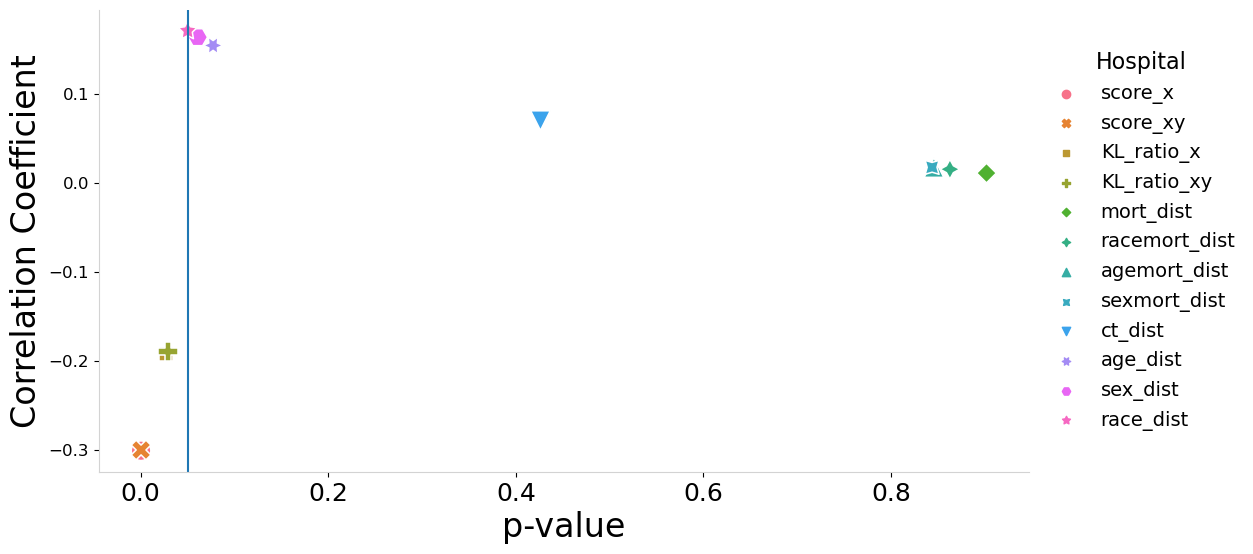

In [1259]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the bar plot
sns.scatterplot(y=corr_coefs, x=p_values,hue=cols,style=cols, s=200)

ax.set_ylabel('Correlation Coefficient')
ax.set_xlabel('p-value')


# sns.scatterplot(data=plot_df, x='OOD', y='Data-Addition', hue='train_hospital', style='train_hospital', s=150)

# # bar_width = 0.5
# # bar_positions = np.arange(len(corr_coefs))
# # bars = ax.bar(bar_positions, corr_coefs, bar_width, align='center')

# # Add column names as x-tick labels
# ax.set_xticks(bar_positions)
# ax.set_xticklabels(cols, rotation=20, ha='right')

# # Add y-axis label
# ax.set_ylabel('Correlation Coefficient')

leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=14)
leg.set_title('Hospital',prop={'size':16})

ax.axvline(0.05)
# # Add p-values above each bar
# for bar, p_val in zip(bars, p_values):
#     height = bar.get_height()
#     ax.annotate(f'p={p_val:.2e}',
#                 xy=(bar.get_x() + bar.get_width() / 2, height),
#                 xytext=(0, 3),
#                 textcoords='offset points',
#                 ha='center', va='bottom')


## Section 4: Data Addition

In [1300]:
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


'LogisticRegression'

In [1320]:
hos=443
# hospital
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i
    
hos_ind = hospital_dict[hos]
# model = "LogisticRegression"
# model = "LGBMClassifier"
model = "LSTM"
n_avg = np.load(f"results/sequential-n/{hos}/{hos}-{model}-avg.npz", allow_pickle=True)
n_std = np.load(f"results/sequential-n/{hos}/{hos}-{model}-std.npz", allow_pickle=True)
dist_shift_avg = np.load(f"results/dist_shift/{model}-n1500-avg.npz", allow_pickle=True)
dist_shift_std = np.load(f"results/dist_shift/{model}-n1500-std.npz", allow_pickle=True)
sequential_best_avg = np.load(f"results/sequential-n/{hos}/{hos}-{model}-best-hospitals-avg.npz", allow_pickle=True)
sequential_best_std = np.load(f"results/sequential-n/{hos}/{hos}-{model}-best-hospitals-std.npz", allow_pickle=True)
sequential_worst_avg = np.load(f"results/sequential-n/{hos}/{hos}-{model}-worst-hospitals-avg.npz", allow_pickle=True)
sequential_worst_std = np.load(f"results/sequential-n/{hos}/{hos}-{model}-worst-hospitals-std.npz", allow_pickle=True)
mixture_avg = np.load(f"results/sequential-n/{hos}/{hos}-mixture-{model}-avg.npz", allow_pickle=True)
mixture_std = np.load(f"results/sequential-n/{hos}/{hos}-mixture-{model}-std.npz", allow_pickle=True)


In [1321]:
plot_df = pd.DataFrame.from_dict(n_avg['AUC'].item(), orient='index', columns=['AUC'])
std_df = pd.DataFrame.from_dict(n_std['AUC'].item(), orient='index', columns=['std'])

plot_df = pd.concat([plot_df, std_df], axis=1)
new_df = plot_df.reset_index(names='n')
new_df['train_hospital'] = hos

In [1322]:
best_df = pd.DataFrame.from_dict(sequential_best_avg['AUC'].item(), orient='index', columns=['Best3-AUC'])
worst_df = pd.DataFrame.from_dict(sequential_worst_avg['AUC'].item(), orient='index', columns=['Worst3-AUC'])
mixture_df = pd.DataFrame.from_dict(mixture_avg['AUC'].item(), orient='index', columns=['Mixture-AUC'])
best_df_std = pd.DataFrame.from_dict(sequential_best_std['AUC'].item(), orient='index', columns=['Best3-std'])
worst_df_std = pd.DataFrame.from_dict(sequential_worst_std['AUC'].item(), orient='index', columns=['Worst3-std'])
mixture_df_std = pd.DataFrame.from_dict(mixture_std['AUC'].item(), orient='index', columns=['Mixture-std'])
plot_df = pd.concat([best_df, worst_df, mixture_df, best_df_std, worst_df_std, mixture_df_std], axis=1)
addition_df = plot_df.reset_index(names='n')

Logistic Regression on Hospital 443


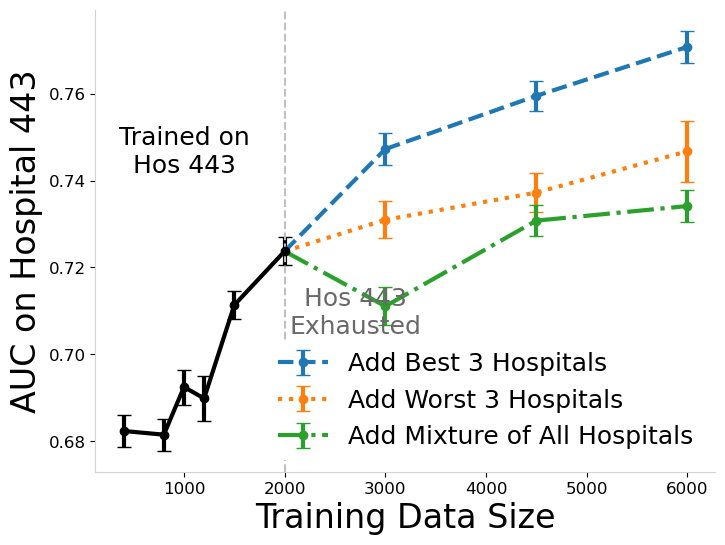

In [1323]:
lw=3

sem_ratio = np.sqrt(5)
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the mean AUC with confidence intervals as vertical bars

hos_df = new_df
ax.errorbar(x=hos_df['n'],
            y=hos_df['AUC'],
            yerr=[hos_df['std']/sem_ratio ,hos_df['std']/sem_ratio],
            fmt='o-',
            capsize=5,
            lw=3,
            color='k'
           )
#             label=f'Use All Data from Hos {hos}')

ax.errorbar(x=addition_df['n'],
            y=addition_df['Best3-AUC'],
            yerr=[addition_df['Best3-std']/sem_ratio ,addition_df['Best3-std']/sem_ratio],
            fmt='o',
            capsize=5,
            lw=lw,
            ls='dashed',
            label=f'Add Best 3 Hospitals')

ax.errorbar(x=addition_df['n'],
            y=addition_df['Worst3-AUC'],
            yerr=[addition_df['Worst3-std']/sem_ratio ,addition_df['Worst3-std']/sem_ratio],
            fmt='o',
            capsize=5,
            lw=lw,
            ls='dotted',
            label=f'Add Worst 3 Hospitals')

ax.errorbar(x=addition_df['n'],
            y=addition_df['Mixture-AUC'],
            yerr=[addition_df['Mixture-std']/sem_ratio ,addition_df['Mixture-std']/sem_ratio],
            fmt='o',
            capsize=5,
            lw=lw,
            ls='dashdot',
            label=f'Add Mixture of All Hospitals')

# Set labels and title
ax.set_xlabel('Training Data Size')
ax.set_ylabel('AUC on Hospital 443')

ax.plot([hos_df['n'].values[-1],addition_df['n'].values[0]],
        [hos_df['AUC'].values[-1], addition_df['Best3-AUC'].values[0]], 
        color='C0', ls='--', lw=lw)
ax.plot([hos_df['n'].values[-1],addition_df['n'].values[0]],
        [hos_df['AUC'].values[-1], addition_df['Worst3-AUC'].values[0]], color='C1', 
        ls='dotted', lw=lw)

ax.plot([hos_df['n'].values[-1],addition_df['n'].values[0]],
        [hos_df['AUC'].values[-1], addition_df['Mixture-AUC'].values[0]], 
        color='C2', ls='dashdot', lw=lw)

# ax.set_title(f'Logistic Regression on Hospital {hos}')
print(f'Logistic Regression on Hospital {hos}')
# Show the legend
ax.legend(frameon=True, loc=4,fontsize=18,framealpha=1., edgecolor='white')
ax.axvline(2000,color='silver',ls='--')

ax.annotate(f'Trained on\nHos {hos}',
            color='k',
            xy=(1000, 0.739),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center', va=va, fontsize=18)

ax.annotate(f'Hos {hos}\nExhausted',
            color='dimgray',
            xy=(2700, 0.702),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center', va=va, fontsize=18)


# Display the plot
plt.savefig(f'figures/seq_hos{hos}_{model}.pdf', bbox_inches='tight')
# plt.show()

Logistic Regression on Hospital 199


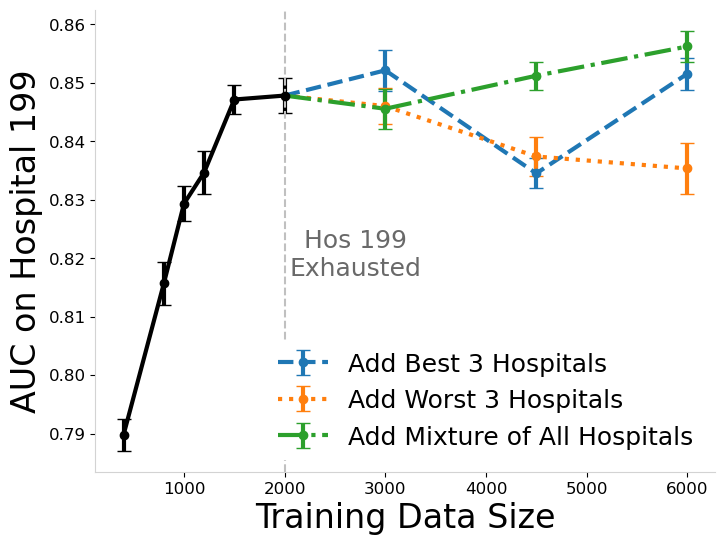

In [1324]:
hos=199
# hospital
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i
    
hos_ind = hospital_dict[hos]
# model = "LogisticRegression"
# model = "LGBMClassifier"
model = "LSTM"
n_avg = np.load(f"results/sequential-n/{hos}/{hos}-{model}-avg.npz", allow_pickle=True)
n_std = np.load(f"results/sequential-n/{hos}/{hos}-{model}-std.npz", allow_pickle=True)
dist_shift_avg = np.load(f"results/dist_shift/{model}-n1500-avg.npz", allow_pickle=True)
dist_shift_std = np.load(f"results/dist_shift/{model}-n1500-std.npz", allow_pickle=True)
sequential_best_avg = np.load(f"results/sequential-n/{hos}/{hos}-{model}-best-hospitals-avg.npz", allow_pickle=True)
sequential_best_std = np.load(f"results/sequential-n/{hos}/{hos}-{model}-best-hospitals-std.npz", allow_pickle=True)
sequential_worst_avg = np.load(f"results/sequential-n/{hos}/{hos}-{model}-worst-hospitals-avg.npz", allow_pickle=True)
sequential_worst_std = np.load(f"results/sequential-n/{hos}/{hos}-{model}-worst-hospitals-std.npz", allow_pickle=True)
mixture_avg = np.load(f"results/sequential-n/{hos}/{hos}-mixture-{model}-avg.npz", allow_pickle=True)
mixture_std = np.load(f"results/sequential-n/{hos}/{hos}-mixture-{model}-std.npz", allow_pickle=True)

plot_df = pd.DataFrame.from_dict(n_avg['AUC'].item(), orient='index', columns=['AUC'])
std_df = pd.DataFrame.from_dict(n_std['AUC'].item(), orient='index', columns=['std'])

plot_df = pd.concat([plot_df, std_df], axis=1)
new_df = plot_df.reset_index(names='n')
new_df['train_hospital'] = hos

best_df = pd.DataFrame.from_dict(sequential_best_avg['AUC'].item(), orient='index', columns=['Best3-AUC'])
worst_df = pd.DataFrame.from_dict(sequential_worst_avg['AUC'].item(), orient='index', columns=['Worst3-AUC'])
mixture_df = pd.DataFrame.from_dict(mixture_avg['AUC'].item(), orient='index', columns=['Mixture-AUC'])
best_df_std = pd.DataFrame.from_dict(sequential_best_std['AUC'].item(), orient='index', columns=['Best3-std'])
worst_df_std = pd.DataFrame.from_dict(sequential_worst_std['AUC'].item(), orient='index', columns=['Worst3-std'])
mixture_df_std = pd.DataFrame.from_dict(mixture_std['AUC'].item(), orient='index', columns=['Mixture-std'])
plot_df = pd.concat([best_df, worst_df, mixture_df, best_df_std, worst_df_std, mixture_df_std], axis=1)
addition_df = plot_df.reset_index(names='n')

lw=3

sem_ratio = np.sqrt(5)
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the mean AUC with confidence intervals as vertical bars

hos_df = new_df
ax.errorbar(x=hos_df['n'],
            y=hos_df['AUC'],
            yerr=[hos_df['std']/sem_ratio ,hos_df['std']/sem_ratio],
            fmt='o-',
            capsize=5,
            lw=3,
            color='k'
           )
#             label=f'Use All Data from Hos {hos}')

ax.errorbar(x=addition_df['n'],
            y=addition_df['Best3-AUC'],
            yerr=[addition_df['Best3-std']/sem_ratio ,addition_df['Best3-std']/sem_ratio],
            fmt='o',
            capsize=5,
            lw=lw,
            ls='dashed',
            label=f'Add Best 3 Hospitals')

ax.errorbar(x=addition_df['n'],
            y=addition_df['Worst3-AUC'],
            yerr=[addition_df['Worst3-std']/sem_ratio ,addition_df['Worst3-std']/sem_ratio],
            fmt='o',
            capsize=5,
            lw=lw,
            ls='dotted',
            label=f'Add Worst 3 Hospitals')

ax.errorbar(x=addition_df['n'],
            y=addition_df['Mixture-AUC'],
            yerr=[addition_df['Mixture-std']/sem_ratio ,addition_df['Mixture-std']/sem_ratio],
            fmt='o',
            capsize=5,
            lw=lw,
            ls='dashdot',
            label=f'Add Mixture of All Hospitals')

# Set labels and title
ax.set_xlabel('Training Data Size')
ax.set_ylabel(f'AUC on Hospital {hos}')

ax.plot([hos_df['n'].values[-1],addition_df['n'].values[0]],
        [hos_df['AUC'].values[-1], addition_df['Best3-AUC'].values[0]], 
        color='C0', ls='--', lw=lw)
ax.plot([hos_df['n'].values[-1],addition_df['n'].values[0]],
        [hos_df['AUC'].values[-1], addition_df['Worst3-AUC'].values[0]], color='C1', 
        ls='dotted', lw=lw)

ax.plot([hos_df['n'].values[-1],addition_df['n'].values[0]],
        [hos_df['AUC'].values[-1], addition_df['Mixture-AUC'].values[0]], 
        color='C2', ls='dashdot', lw=lw)

# ax.set_title(f'Logistic Regression on Hospital {hos}')
print(f'Logistic Regression on Hospital {hos}')
# Show the legend
ax.legend(frameon=True, loc=4,fontsize=18,framealpha=1., edgecolor='white')
ax.axvline(2000,color='silver',ls='--')

ax.annotate(f'Trained on\nHos {hos}',
            color='k',
            xy=(1000, 0.870),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center', va=va, fontsize=18)

ax.annotate(f'Hos {hos}\nExhausted',
            color='dimgray',
            xy=(2700, 0.815),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center', va=va, fontsize=18)


# Display the plot
plt.savefig(f'figures/seq_hos{hos}_{model}.pdf', bbox_inches='tight')
# plt.show()

In [1276]:
# 443: 0.737726 -> (0.764739, 0.752954, 0.738016)
# 199: 0.842022 -> (0.855373, 0.842143, 0.826456)


# 443: % (0.03661657580185591, 0.020641810102937974, 0.0003930998771901932) -> -92.148, 0.774, 
# 199: % (0.015855880250159736, 0.015712178541653393, -0.03434233309818518) -> 1.4617007296745848, 1.4575163398692823

In [1292]:
(0.015855880250159736 + 0.03434233309818518) / 0.03434233309818518

1.4617007296745848

In [1293]:
(2.05 - 3.66) / 2.05

-0.7853658536585368

In [1282]:
(0.738016 - 0.737726) / 0.737726

0.0003930998771901932

## Sequential Plot with Disparity

In [1102]:
for k in sequential_best_avg.files:
    print(k)

loss
AUC
PR
ACC_TEST
BACC_TEST
AUC_TEST
gender0_AUC_TEST
gender0_BACC_TEST
gender0_ACC_TEST
gender1_AUC_TEST
gender1_BACC_TEST
gender1_ACC_TEST
race0_AUC_TEST
race0_BACC_TEST
race0_ACC_TEST
race3_AUC_TEST
race3_BACC_TEST
race3_ACC_TEST
race2_AUC_TEST
race2_BACC_TEST
race2_ACC_TEST
race1_AUC_TEST
race1_BACC_TEST
race1_ACC_TEST


In [1158]:
# dist_shift_avg['race0_ACC_TEST']
mixture_avg['race0_ACC_TEST']

array({3000: 0.5833333333333333, 4500: 0.8333333333333333, 6000: 0.8333333333333333},
      dtype=object)

In [1161]:
new_df

,n,race3_ACC_TEST,std,train_hospital
0,400,0.925658,0.007998,199
1,800,0.924460,0.007906,199
2,1000,0.933868,0.004304,199
3,1200,0.927155,0.005308,199
4,1500,0.928720,0.005888,199
5,2000,0.925080,0.004234,199


In [1164]:
race_acc_fields = ['race0_ACC_TEST', 'race1_ACC_TEST', 'race2_ACC_TEST', 'race3_ACC_TEST']

In [1297]:
n_std['race0_ACC_TEST']

array({400: 0.058925565098878946, 800: 0.17677669529663687, 1000: 0.17677669529663687, 1200: 0.17677669529663687, 1500: 0.17677669529663687, 2000: 0.17677669529663687},
      dtype=object)

In [1298]:
n_std['race1_ACC_TEST']

array({400: 0.028082815872435274, 800: 0.025983731852596812, 1000: 0.025983731852596812, 1200: 0.03657114381135463, 1500: 0.03657114381135463, 2000: 0.021553896938860704},
      dtype=object)

Logistic Regression on Hospital 443


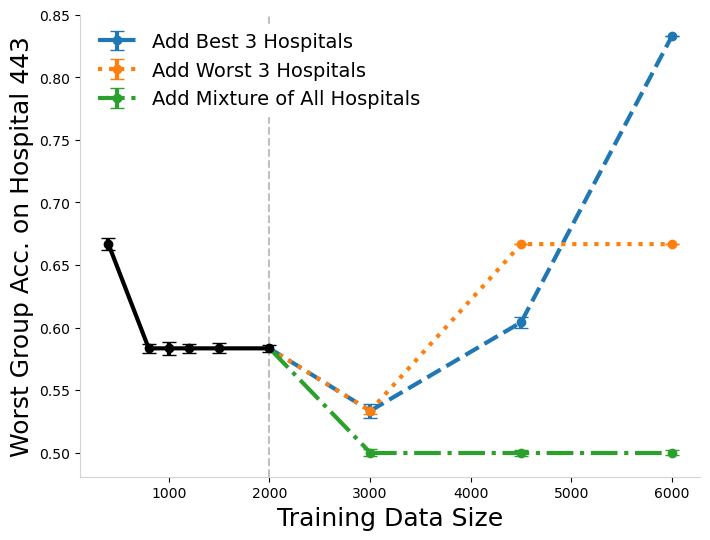

In [1220]:
hos=443
metric = 'worst'

# hospital
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i

hos_ind = hospital_dict[hos]
# model = "LogisticRegression"
model = "LogisticRegression"
n_avg = np.load(f"results/sequential-n/{hos}/{hos}-{model}-avg.npz", allow_pickle=True)
n_std = np.load(f"results/sequential-n/{hos}/{hos}-{model}-std.npz", allow_pickle=True)
dist_shift_avg = np.load(f"results/dist_shift/{model}-n1500-avg.npz", allow_pickle=True)
dist_shift_std = np.load(f"results/dist_shift/{model}-n1500-std.npz", allow_pickle=True)
sequential_best_avg = np.load(f"results/sequential-n/{hos}/{hos}-{model}-best-hospitals-avg.npz", allow_pickle=True)
sequential_best_std = np.load(f"results/sequential-n/{hos}/{hos}-{model}-best-hospitals-std.npz", allow_pickle=True)
sequential_worst_avg = np.load(f"results/sequential-n/{hos}/{hos}-{model}-worst-hospitals-avg.npz", allow_pickle=True)
sequential_worst_std = np.load(f"results/sequential-n/{hos}/{hos}-{model}-worst-hospitals-std.npz", allow_pickle=True)
mixture_avg = np.load(f"results/sequential-n/{hos}/{hos}-mixture-{model}-avg.npz", allow_pickle=True)
mixture_std = np.load(f"results/sequential-n/{hos}/{hos}-mixture-{model}-std.npz", allow_pickle=True)



def get_metric_item(source_df,name_col=None,metric='disparity'):
    dfs = list()

    for col in race_acc_fields:
        df = pd.DataFrame.from_dict(source_df[col].item(), orient='index', columns=[col])
        dfs.append(df)

    race_df = pd.concat(dfs,axis=1)

    race_df['disparity'] = race_df[race_acc_fields].max(axis=1) - race_df[race_acc_fields].min(axis=1)
    race_df['worst'] = race_df[race_acc_fields].min(axis=1)
    if name_col:
        race_df[[name_col]] = race_df[[metric]]
        return race_df[[name_col]]
    else:
        return race_df[[metric]]



# plot_df = pd.DataFrame.from_dict(n_avg[metric].item(), orient='index', columns=[metric])
# std_df = pd.DataFrame.from_dict(n_std[metric].item(), orient='index', columns=['std'])
plot_df = get_metric_item(n_avg, metric=metric, name_col=metric)
std_df = get_metric_item(n_std, metric=metric, name_col='std')

# create hos_df
plot_df = pd.concat([plot_df, std_df], axis=1)
new_df = plot_df.reset_index(names='n')
new_df['train_hospital'] = hos

# create 
# best_df = pd.DataFrame.from_dict(sequential_best_avg[metric].item(), orient='index', columns=[f'Best3-{metric}'])
# worst_df = pd.DataFrame.from_dict(sequential_worst_avg[metric].item(), orient='index', columns=[f'Worst3-{metric}'])
# mixture_df = pd.DataFrame.from_dict(mixture_avg[metric].item(), orient='index', columns=[f'Mixture-{metric}'])
# best_df_std = pd.DataFrame.from_dict(sequential_best_std[metric].item(), orient='index', columns=['Best3-std'])
# worst_df_std = pd.DataFrame.from_dict(sequential_worst_std[metric].item(), orient='index', columns=['Worst3-std'])
# mixture_df_std = pd.DataFrame.from_dict(mixture_std[metric].item(), orient='index', columns=['Mixture-std'])

best_df = get_metric_item(sequential_best_avg, metric=metric, name_col=f'Best3-{metric}')
worst_df = get_metric_item(sequential_worst_avg, metric=metric, name_col=f'Worst3-{metric}')
mixture_df = get_metric_item(mixture_avg, metric=metric, name_col=f'Mixture-{metric}')
best_df_std = get_metric_item(sequential_best_std, metric=metric, name_col='Best3-std')
worst_df_std = get_metric_item(sequential_worst_std, metric=metric, name_col='Worst3-std')
mixture_df_std = get_metric_item(mixture_std, metric=metric, name_col='Mixture-std')

plot_df = pd.concat([best_df, worst_df, mixture_df, best_df_std, worst_df_std, mixture_df_std], axis=1)
addition_df = plot_df.reset_index(names='n')

addition_df = addition_df.sort_values('n')

lw=3

sem_ratio = np.sqrt(5)
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the mean AUC with confidence intervals as vertical bars

hos_df = new_df
ax.errorbar(x=hos_df['n'],
            y=hos_df[metric],
            yerr=[hos_df['std']/sem_ratio ,hos_df['std']/sem_ratio],
            fmt='o-',
            capsize=5,
            lw=3,
            color='k'
           )
#             label=f'Use All Data from Hos {hos}')

ax.errorbar(x=addition_df['n'],
            y=addition_df[f'Best3-{metric}'],
            yerr=[addition_df['Best3-std']/sem_ratio ,addition_df['Best3-std']/sem_ratio],
            fmt='o',
            capsize=5,
            lw=lw,
            ls='dashed',
            label=f'Add Best 3 Hospitals')

ax.errorbar(x=addition_df['n'],
            y=addition_df[f'Worst3-{metric}'],
            yerr=[addition_df['Worst3-std']/sem_ratio ,addition_df['Worst3-std']/sem_ratio],
            fmt='o',
            capsize=5,
            lw=lw,
            ls='dotted',
            label=f'Add Worst 3 Hospitals')

ax.errorbar(x=addition_df['n'],
            y=addition_df[f'Mixture-{metric}'],
            yerr=[addition_df['Mixture-std']/sem_ratio ,addition_df['Mixture-std']/sem_ratio],
            fmt='o',
            capsize=5,
            lw=lw,
            ls='dashdot',
            label=f'Add Mixture of All Hospitals')

# Set labels and title
ax.set_xlabel('Training Data Size')
ylabel_metric = metric.title() if metric == 'disparity' else 'Worst Group Acc.'
ax.set_ylabel(f'{ylabel_metric} on Hospital {hos}')

ax.plot([hos_df['n'].values[-1],addition_df['n'].values[0]],
        [hos_df[metric].values[-1], addition_df[f'Best3-{metric}'].values[0]], 
        color='C0', ls='--', lw=lw)
ax.plot([hos_df['n'].values[-1],addition_df['n'].values[0]],
        [hos_df[metric].values[-1], addition_df[f'Worst3-{metric}'].values[0]], color='C1', 
        ls='dotted', lw=lw)

ax.plot([hos_df['n'].values[-1],addition_df['n'].values[0]],
        [hos_df[f'{metric}'].values[-1], addition_df[f'Mixture-{metric}'].values[0]], 
        color='C2', ls='dashdot', lw=lw)

# ax.set_title(f'Logistic Regression on Hospital {hos}')
print(f'Logistic Regression on Hospital {hos}')
# Show the legend
ax.legend(frameon=True, loc='best',fontsize=14,framealpha=1., edgecolor='white')
ax.axvline(2000,color='silver',ls='--')

# ax.annotate(f'Trained on\nHos {hos}',
#             color='k',
#             xy=(1000, 0.841),
#             xytext=(0, 5),
#             textcoords='offset points',
#             ha='center', va=va, fontsize=18)

# ax.annotate(f'Hos {hos}\nExhausted',
#             color='dimgray',
#             xy=(2700, 0.8),
#             xytext=(0, 5),
#             textcoords='offset points',
#             ha='center', va=va, fontsize=18)


# Display the plot
plt.savefig(f'figures/seq_hos{hos}_{metric}_lr.pdf', bbox_inches='tight')
# plt.show()

In [1056]:
"""
# TODOS: 
- capped Shift LSTM add data
- capped addition (LSTM running / LR, LGBM need to be loaded)
- Hosp 199 (by score heuristic) LogReg x {Sequential, Mixture}

- Hosp 433 (by score heuristic) {LSTM, LGBM} x {Sequential, Mixture}
- Hosp 199 (by score heuristic) {LSTM, LGBM} x {Sequential, Mixture}

- Hosp 443 (by ground truth) -> LogReg x {Sequential, Mixture}
"""

'\n# TODOS: \n- capped Shift LSTM add data\n- capped addition (LSTM running / LR, LGBM need to be loaded)\n- Hosp 199 (by score heuristic) LogReg x {Sequential, Mixture}\n\n- Hosp 433 (by score heuristic) {LSTM, LGBM} x {Sequential, Mixture}\n- Hosp 199 (by score heuristic) {LSTM, LGBM} x {Sequential, Mixture}\n\n- Hosp 443 (by ground truth) -> LogReg x {Sequential, Mixture}\n'